<a href="https://colab.research.google.com/github/TMulosmani/ESRGANImageSuperResolution/blob/main/Image_Super_Resolution_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I use a pretrained ESRGAN model to superscale images from TFHub


In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

TEST_IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

--2022-09-26 17:41:20--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.003s  

2022-09-26 17:41:20 (11.5 MB/s) - ‘original.png’ saved [34146/34146]



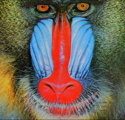

In [3]:
Image.open(TEST_IMAGE_PATH)


In [4]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)
  

In [5]:
%matplotlib inline
def plot_both_images(image1,title1,image2,title2):
  """
    Plots images from image tensors adjacent to each other.
    Args:
      image1: 3D image tensor. [height, width, channels].
      title1: Title to display for image1.
      image2: 3D image tensor. [height, width, channels].
      title1: Title to display for image2.
  """
  image1 = tf.squeeze(image1)
  image1 = np.asarray(image1)
  image1 = tf.clip_by_value(image1, 0, 255) #set values from 0-255
  image1 = Image.fromarray(tf.cast(image1, tf.uint8).numpy())

  image2 = tf.squeeze(image2)
  image2 = np.asarray(image2)
  image2 = tf.clip_by_value(image2, 0, 255)
  image2 = Image.fromarray(tf.cast(image2, tf.uint8).numpy())

  fig = plt.figure(figsize=(20,20))
  
  # Adds a subplot at the 1st position
  fig.add_subplot(2, 2, 1)
    
  # showing image
  plt.imshow(image1)
  plt.axis('off')
  plt.title(title1)
    
  # Adds a subplot at the 2nd position
  fig.add_subplot(2, 2, 2)
    
  # showing image
  plt.imshow(image2)
  plt.axis('off')
  plt.title(title2)


Saved as original_image.jpg


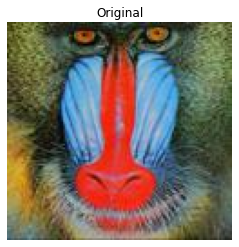

In [6]:
hr_image = preprocess_image(TEST_IMAGE_PATH)

# Plotting Original Resolution image
save_image(tf.squeeze(hr_image), filename="original_image")

plt.imshow(tf.image.decode_image(tf.io.read_file("original_image.jpg")))
plt.axis('off')
plt.title("Original")
plt.show()


Load the pretrained model from TF Hub


In [7]:
model = hub.load(SAVED_MODEL_PATH)

Testing the model


In [8]:
start = time.time()
fake_image = model(hr_image)

print("Time Taken: %f" % (time.time() - start))

Time Taken: 3.428026


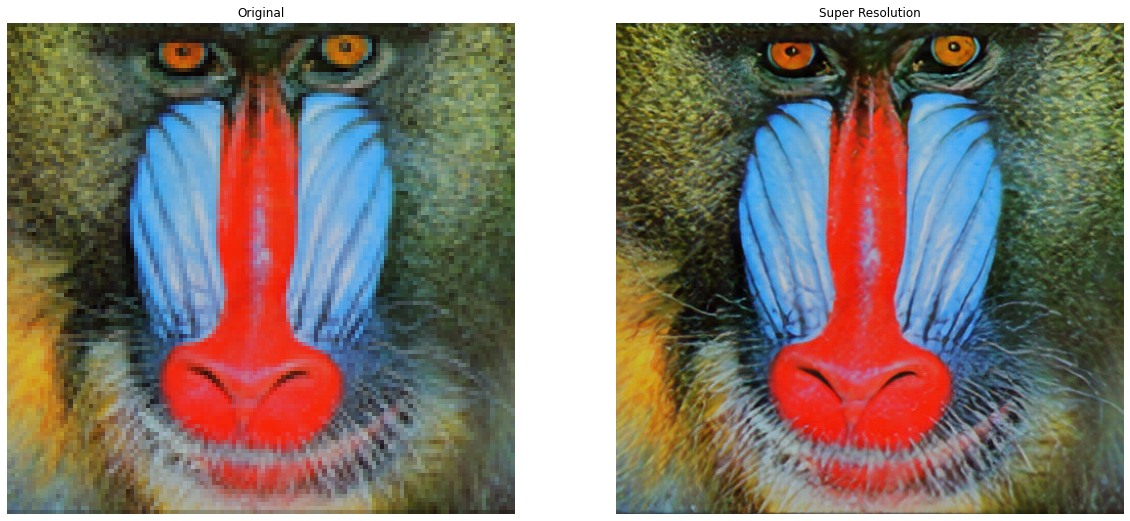

In [9]:
plot_both_images(hr_image, "Original", fake_image, "Super Resolution")

Let's test this on other images


In [10]:
#helper function to downsample images bicubically
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image


BDF32B4D-6922-490E-98EE-7901AD613636_1_105_c.jpeg
36521037-DA07-48A6-93A4-2EC887553D5B_1_105_c.jpeg
6410F99F-6AE2-48FA-A967-D0C849FE12ED_1_105_c.jpeg
3533A586-0F1B-49E6-8639-463AA483DFBB_1_105_c.jpeg
2D9BBF0A-BA9C-4509-885B-DEECDA0667F1_1_105_c.jpeg


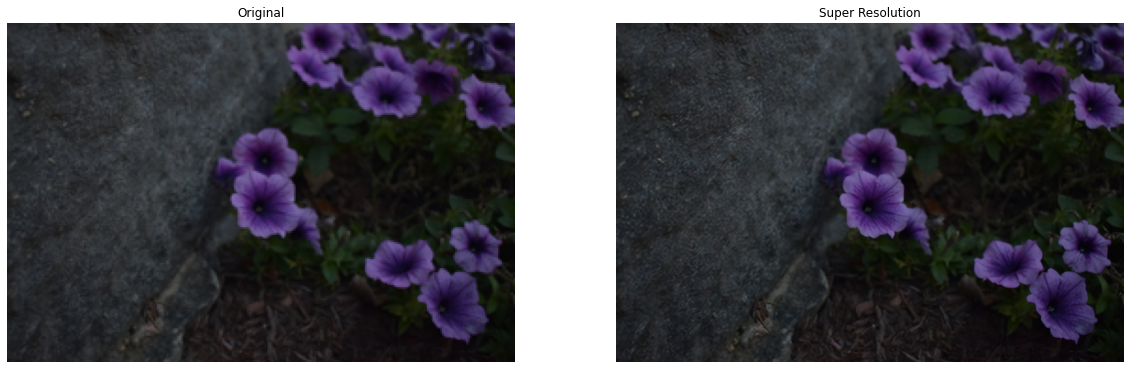

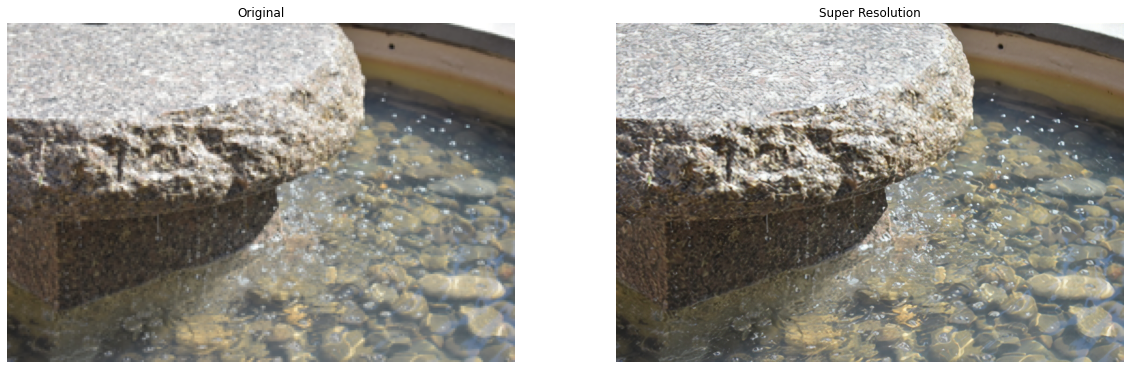

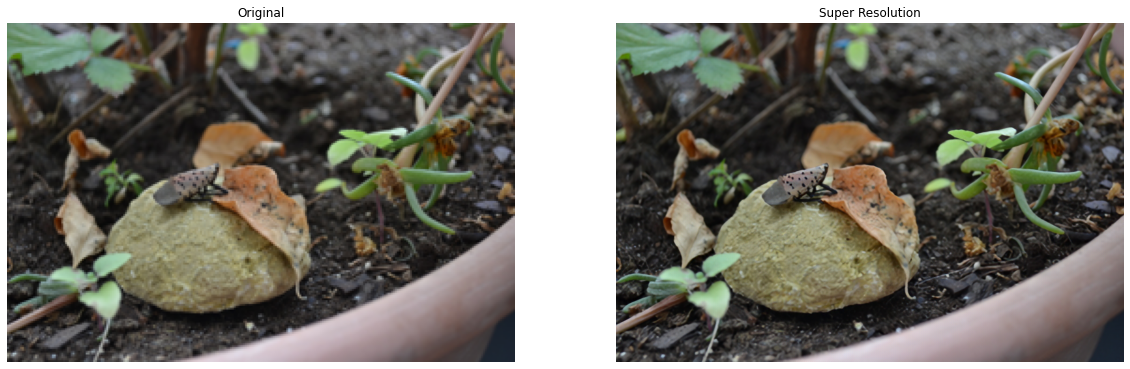

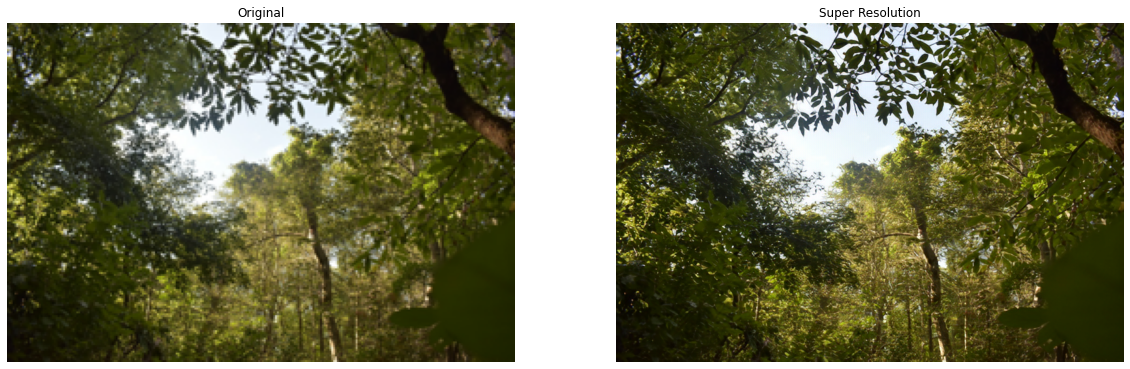

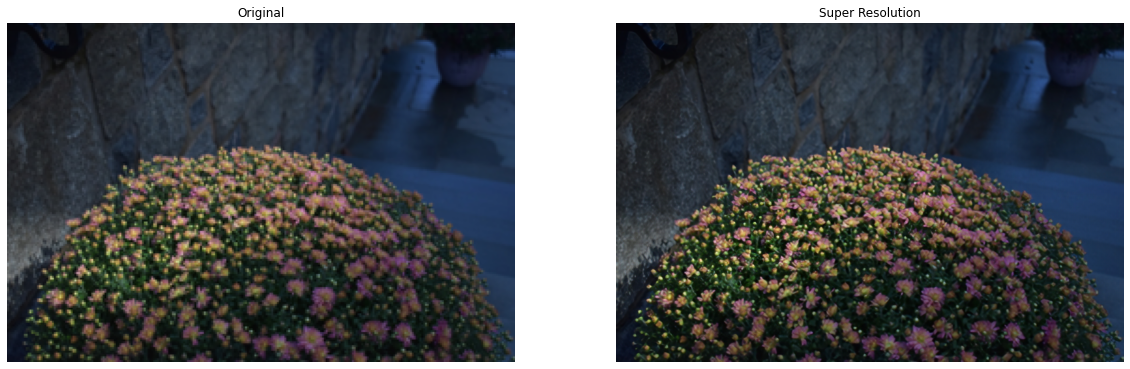

In [11]:
for image_path in os.listdir("test_images"):
    if image_path != ".ipynb_checkpoints":
      print(image_path)
      test_image = preprocess_image(os.path.join("test_images",image_path))
      test_image = downscale_image(tf.squeeze(test_image))
      result_image = model(test_image)
      plot_both_images(test_image, "Original", result_image, "Super Resolution")
